<a href="https://colab.research.google.com/github/TanmayTopkhanewale/Political-Persuasion-Analysis-Uplift-Modeling-/blob/main/G_Political_Persuasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install causalml

In [ ]:
!pip install catboost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (13, 7)


We are importing all the models so that we can across multiple models and judge the metrics accordingly.

In [ ]:
df = pd.read_csv("Voter-Persuasion.csv")
print(f"Loaded dataset with shape: {df.shape}")

Loaded dataset with shape: (10000, 79)


The following is the null value check

In [ ]:
display(df.head())
print("\nData info:")
df.info()
print("\nMissing values:\n", df.isnull().sum()[df.isnull().sum() > 0])
print("\nTarget balance:\n", df['MOVED_A'].value_counts(normalize=True))
print("\nTreatment (MESSAGE_A) balance:\n", df['MESSAGE_A'].value_counts(normalize=True))
print("\nPartitions:\n", df['Partition'].value_counts())

,VOTER_ID,SET_NO,OPP_SEX,AGE,HH_ND,HH_NR,HH_NI,MED_AGE,NH_WHITE,NH_AA,...,CAND2S,MESSAGE_A,MESSAGE_A_REV,I3,CAND1_UND,CAND2_UND,MOVED_AD,MOVED_A,opposite,Partition
0,193801,2,0,28,1,1,1,37,61,34,...,S,1,0,N,N,N,N,0,1,V
1,627701,1,0,53,2,0,0,46,87,8,...,S,1,0,N,N,N,N,0,1,T
2,306924,2,0,68,2,1,0,41,23,64,...,L,1,0,N,N,N,Y,1,0,T
3,547609,1,0,66,0,2,0,35,53,29,...,S,1,0,N,N,N,N,0,1,T
4,141105,3,0,23,0,3,1,42,74,18,...,S,1,0,N,N,N,N,0,1,T



Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   VOTER_ID       10000 non-null  int64 
 1   SET_NO         10000 non-null  int64 
 2   OPP_SEX        10000 non-null  int64 
 3   AGE            10000 non-null  int64 
 4   HH_ND          10000 non-null  int64 
 5   HH_NR          10000 non-null  int64 
 6   HH_NI          10000 non-null  int64 
 7   MED_AGE        10000 non-null  int64 
 8   NH_WHITE       10000 non-null  int64 
 9   NH_AA          10000 non-null  int64 
 10  NH_ASIAN       10000 non-null  int64 
 11  NH_MULT        10000 non-null  int64 
 12  HISP           10000 non-null  int64 
 13  COMM_LT10      10000 non-null  int64 
 14  COMM_609P      10000 non-null  int64 
 15  MED_HH_INC     10000 non-null  int64 
 16  COMM_CAR       10000 non-null  int64 
 17  COMM_CP        10000 non-null  int64 
 18  COMM_PT        

These are the visualizations for the treatment and control variable, and also how the data is partitioned in Validation and Training set.

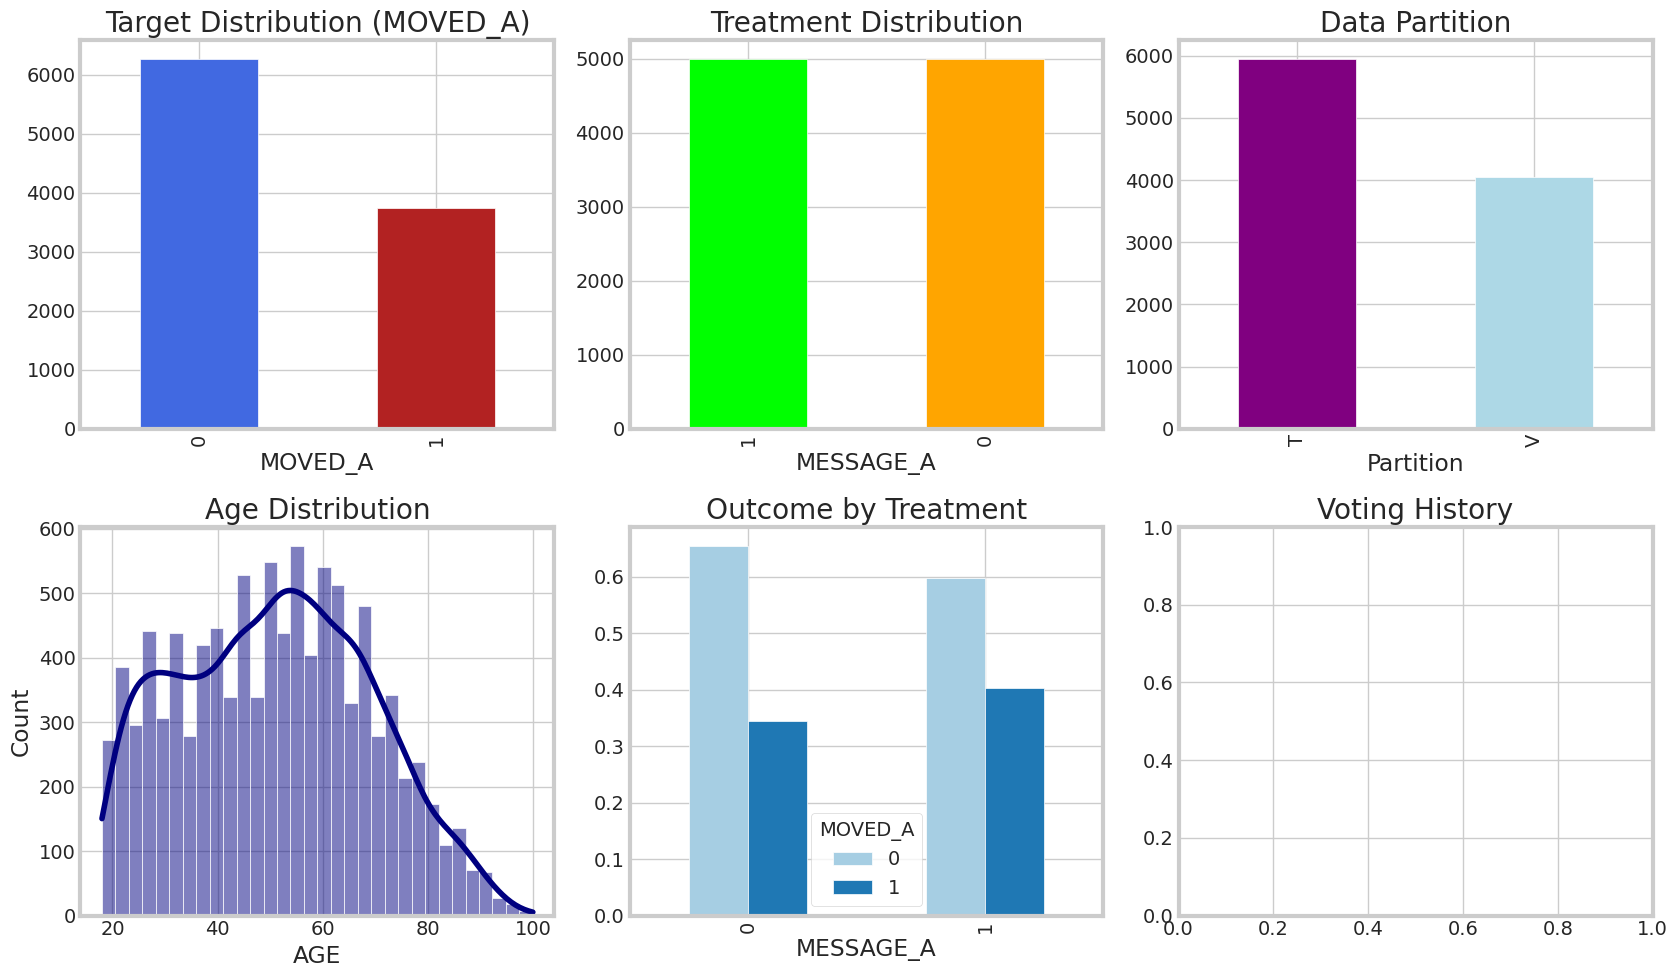

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(17, 10))
df['MOVED_A'].value_counts().plot(kind='bar', ax=axes[0,0], color=['royalblue', 'firebrick'])
axes[0,0].set_title('Target Distribution (MOVED_A)')
df['MESSAGE_A'].value_counts().plot(kind='bar', ax=axes[0,1], color=['lime', 'orange'])
axes[0,1].set_title('Treatment Distribution')
df['Partition'].value_counts().plot(kind='bar', ax=axes[0,2], color=['purple', 'lightblue'])
axes[0,2].set_title('Data Partition')
sns.histplot(df['AGE'], ax=axes[1,0], kde=True, color='navy')
axes[1,0].set_title('Age Distribution')
pd.crosstab(df['MESSAGE_A'], df['MOVED_A'], normalize='index').plot(kind='bar', ax=axes[1,1], legend=True)
axes[1,1].set_title('Outcome by Treatment')
if 'VG_08G' in df.columns: df[[c for c in df if c.startswith('VG_')]].sum().plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Voting History')
plt.tight_layout()
plt.show()

Outlier check with respect to the MOVED_A variable.

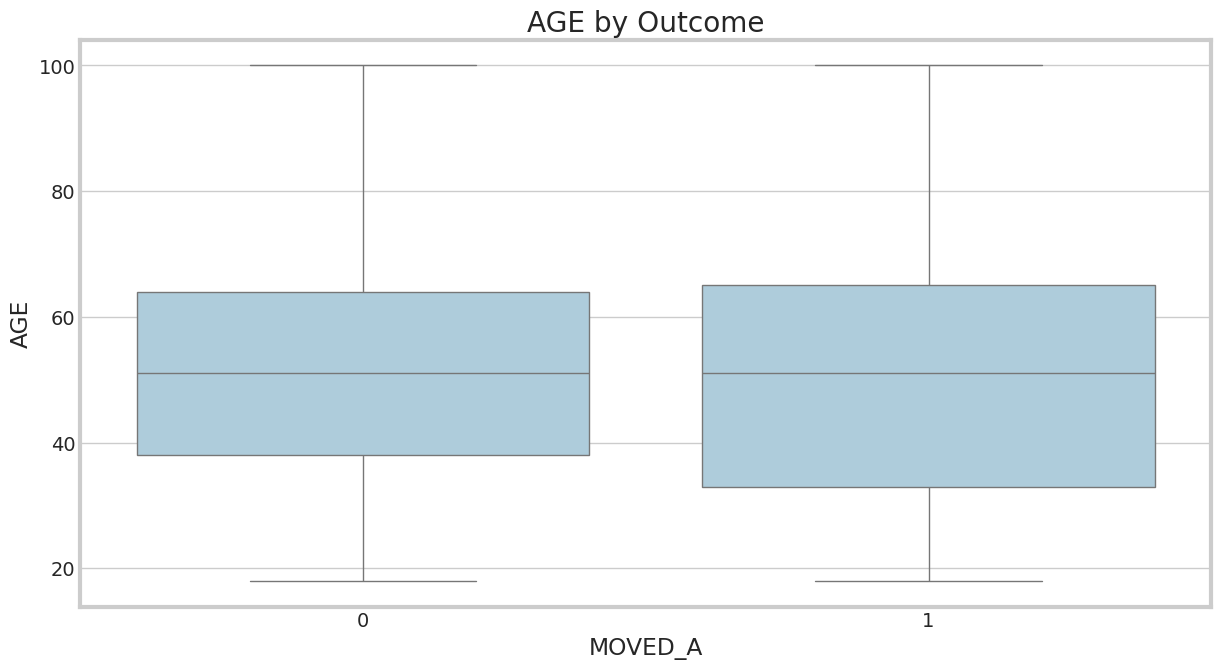

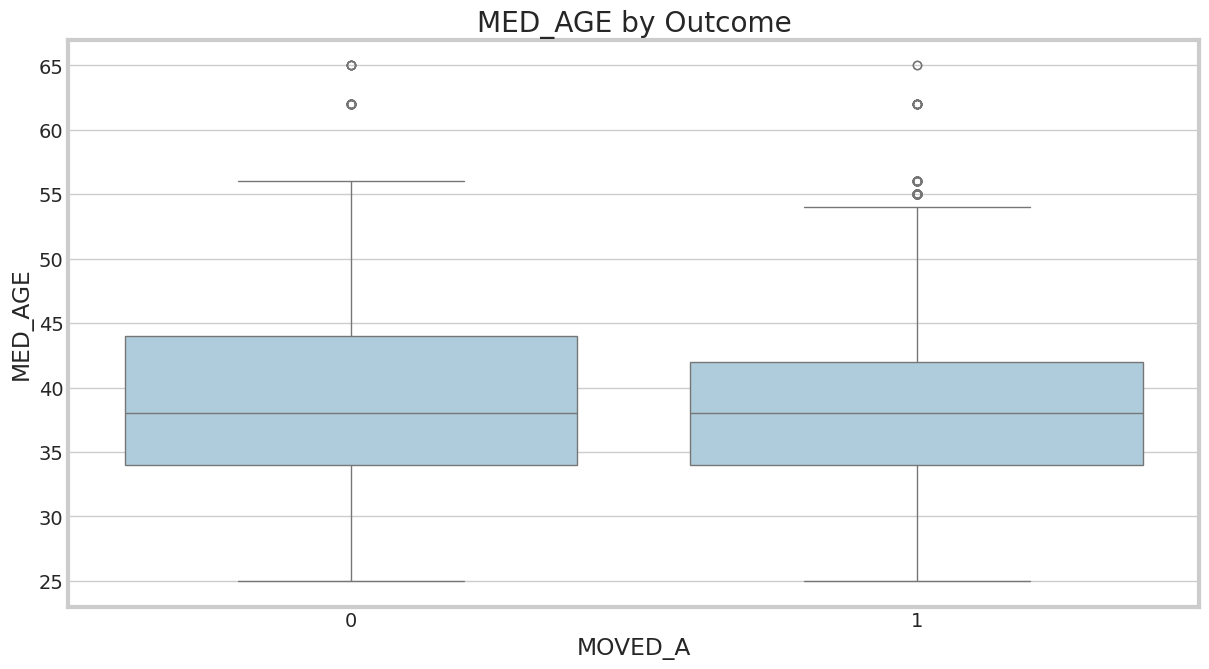

In [ ]:
for col in ['AGE', 'HOUSEHOLD_SIZE', 'MED_AGE']:
    if col in df:
        sns.boxplot(x='MOVED_A', y=col, data=df)
        plt.title(f'{col} by Outcome')
        plt.show()

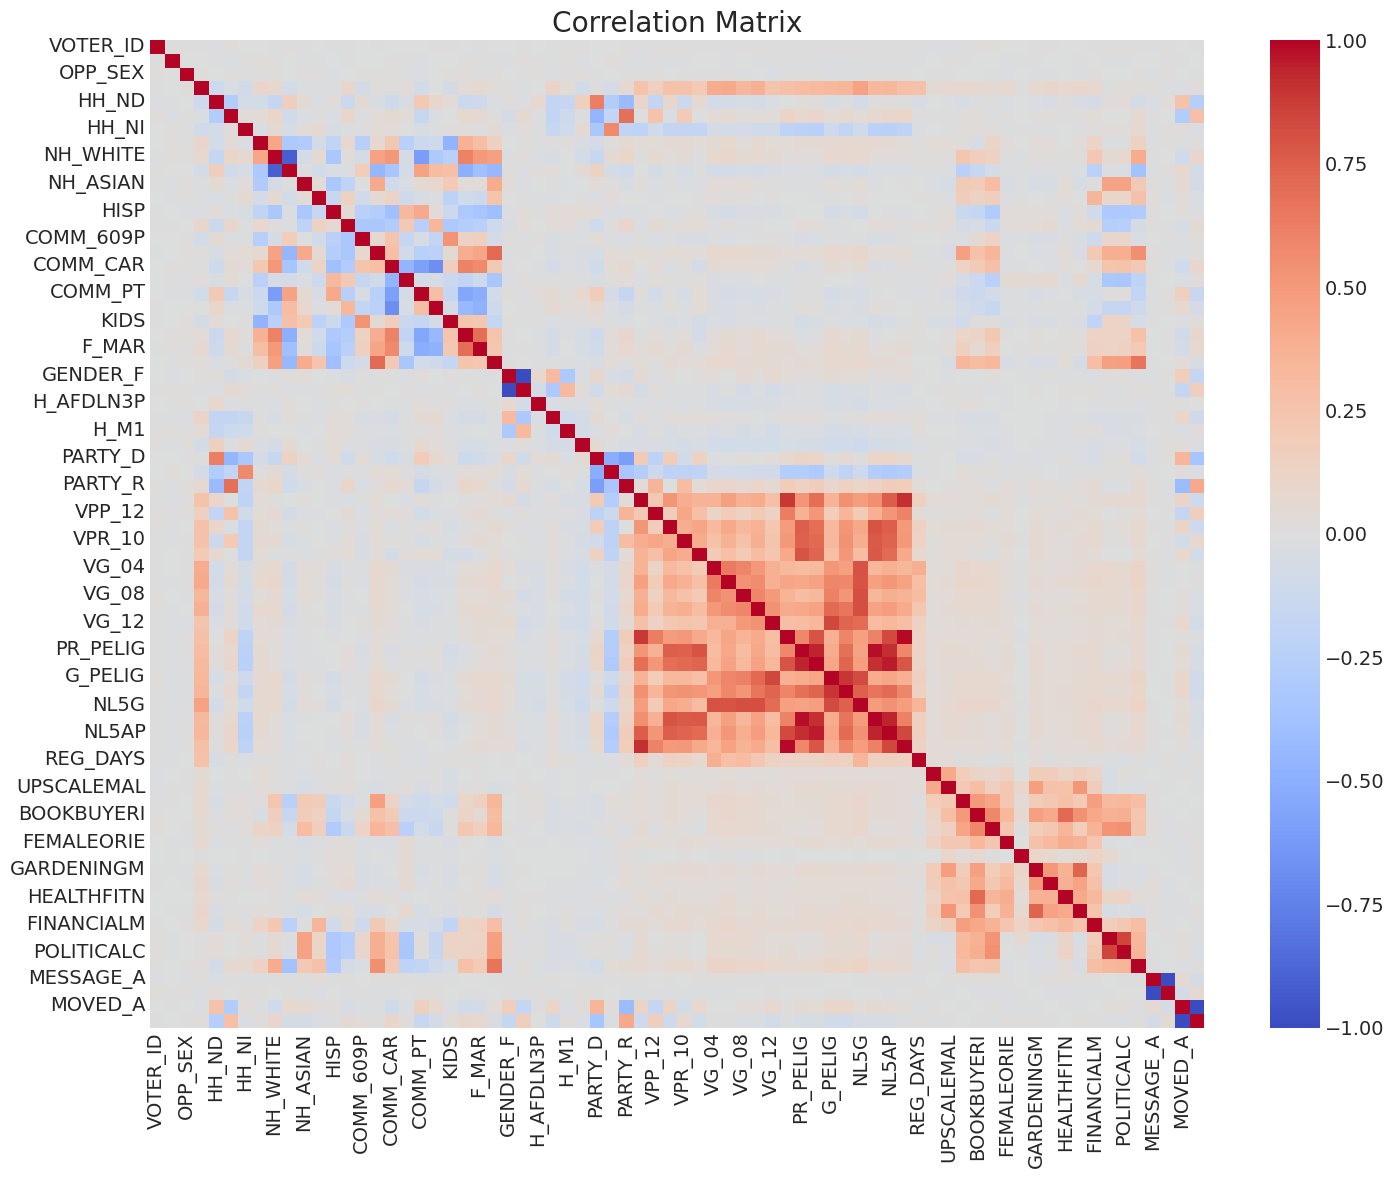

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.select_dtypes(np.number).corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

We will be making two matrices one before categorical encoding and one after, to check the variables causing leakage.

In [ ]:
target = 'MOVED_A'
exclude = ['VOTER_ID', 'MOVED_A', 'MOVED_AD', 'Partition', 'opposite', 'MESSAGE_A_REV']

# Identify categorical columns (before creating features list)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in exclude]

if categorical_cols:
    print(f"\nApplying One-Hot Encoding to {len(categorical_cols)} categorical columns:")
    print(categorical_cols)
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
    print(f" OHE complete. New shape: {df.shape}")
else:
    print(" No categorical columns found for OHE.")


Applying One-Hot Encoding to 5 categorical columns:
['CAND1S', 'CAND2S', 'I3', 'CAND1_UND', 'CAND2_UND']
 OHE complete. New shape: (10000, 81)


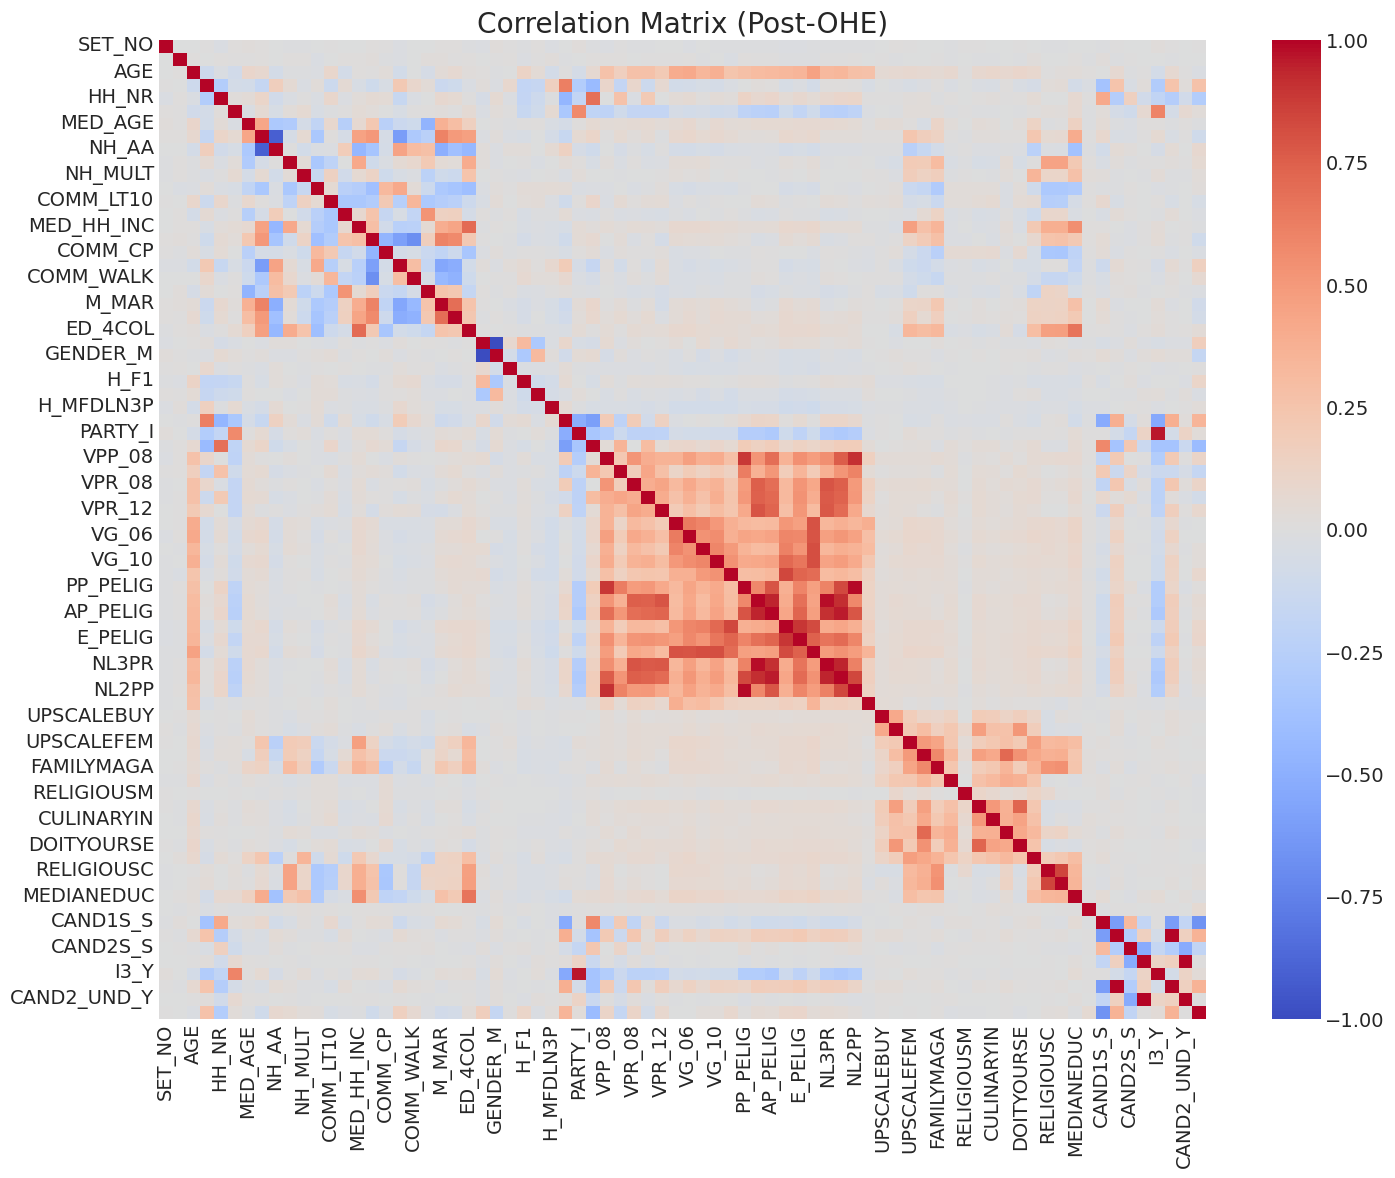

In [ ]:
feature_candidates = [c for c in df.columns if c not in exclude]

plt.figure(figsize=(15, 12))
corr_matrix = df[feature_candidates + [target]].select_dtypes(np.number).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Post-OHE)')
plt.tight_layout()
plt.show()

In [ ]:
corrs = df[feature_candidates].corrwith(df[target]).abs().sort_values(ascending=False)
print("\nTop 15 features by abs correlation to MOVED_A:\n", corrs[:15].to_string())



Top 15 features by abs correlation to MOVED_A:
 CAND1S_S       0.657461
PARTY_R        0.415191
CAND1S_U       0.366541
CAND1_UND_Y    0.366541
PARTY_D        0.345692
HH_NR          0.279504
HH_ND          0.259323
CAND2S_S       0.187660
VPP_12         0.171780
GENDER_F       0.167524
GENDER_M       0.167524
COMM_PT        0.155096
VPP_08         0.115435
VPR_08         0.110937
H_F1           0.108169


In [ ]:
leak_threshold = 0.95
leaky_cols = corrs[corrs > leak_threshold].index.tolist()
print(f"\nRemoving {len(leaky_cols)} leaky features: {leaky_cols}")
features = [c for c in feature_candidates if c not in leaky_cols]
print(f"Final feature count: {len(features)}")


Removing 0 leaky features: []
Final feature count: 75


In [ ]:
df_train = df[df['Partition'] == 'T'].copy()
df_valid = df[df['Partition'] == 'V'].copy()
y_train = df_train[target]
y_valid = df_valid[target]
X_train_full = df_train[features]
X_valid_full = df_valid[features]

In [ ]:
print(f"\nTrain set: {X_train_full.shape}, Valid set: {X_valid_full.shape}")


Train set: (5948, 75), Valid set: (4052, 75)


Model with MESSAGE_A (Treatment-Aware):
Includes the treatment variable (MESSAGE_A). Predicts voter outcome considering whether the persuasive message was received. Enables calculation of personalized uplift—the effect of the message on each voter.

Model without MESSAGE_A (Baseline):
Excludes the treatment variable. Predicts voter outcome using only voter features, ignoring the impact of the message. Acts as a baseline for comparison.

In essence:
The “with” model measures the message’s effect; the “without” model shows what happens if you ignore it. Comparing both reveals the true impact of persuasion.

In [ ]:
features_with_A = features + ['MESSAGE_A'] if 'MESSAGE_A' not in features else features.copy()
X_train_with_A = df_train[features_with_A].copy()
X_valid_with_A = df_valid[features_with_A].copy()

model_with_A = GradientBoostingClassifier(random_state=42)
model_with_A.fit(X_train_with_A, y_train)
print(" Model fitted with A")

 Model fitted with A


In [ ]:
features_no_A = [c for c in features if c != 'MESSAGE_A']
X_train_no_A = df_train[features_no_A].copy()
X_valid_no_A = df_valid[features_no_A].copy()

model_no_A = GradientBoostingClassifier(random_state=42)
model_no_A.fit(X_train_no_A, y_train)
print(" baseline (propensity) model fitted without MESSAGE_A.")


 baseline (propensity) model fitted without MESSAGE_A.


In [ ]:
for m, Xv, name in [
    (model_with_A, X_valid_with_A, 'With MESSAGE_A'),
    (model_no_A, X_valid_no_A, 'Without MESSAGE_A')]:
    y_prob = m.predict_proba(Xv)[:,1]
    y_pred = (y_prob > 0.5).astype(int)
    print(f"Model: {name}")
    print(f" AUC: {roc_auc_score(y_valid, y_prob):.4f}")
    print(f" F1: {f1_score(y_valid, y_pred):.4f}")
    print(f" Accuracy: {accuracy_score(y_valid, y_pred):.4f}")
    print(f" Precision: {precision_score(y_valid, y_pred):.4f}")
    print(f" Recall: {recall_score(y_valid, y_pred):.4f}")
    print("\n  Classification report:\n", classification_report(y_valid, y_pred))


Model: With MESSAGE_A
 AUC: 0.9896
 F1: 0.9361
 Accuracy: 0.9516
 Precision: 0.9054
 Recall: 0.9689

  Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      2571
           1       0.91      0.97      0.94      1481

    accuracy                           0.95      4052
   macro avg       0.94      0.96      0.95      4052
weighted avg       0.95      0.95      0.95      4052

Model: Without MESSAGE_A
 AUC: 0.9895
 F1: 0.9359
 Accuracy: 0.9516
 Precision: 0.9069
 Recall: 0.9669

  Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      2571
           1       0.91      0.97      0.94      1481

    accuracy                           0.95      4052
   macro avg       0.94      0.95      0.95      4052
weighted avg       0.95      0.95      0.95      4052




UPLIFT ANALYSIS
First 5 personalized uplift scores:
[-0.00709319  0.0224674  -0.00032502  0.00888689  0.06496576]

Mean uplift: 0.0189
Median uplift: 0.0019
Percent positive uplift: 78.43%
Percent negative uplift: 21.57%


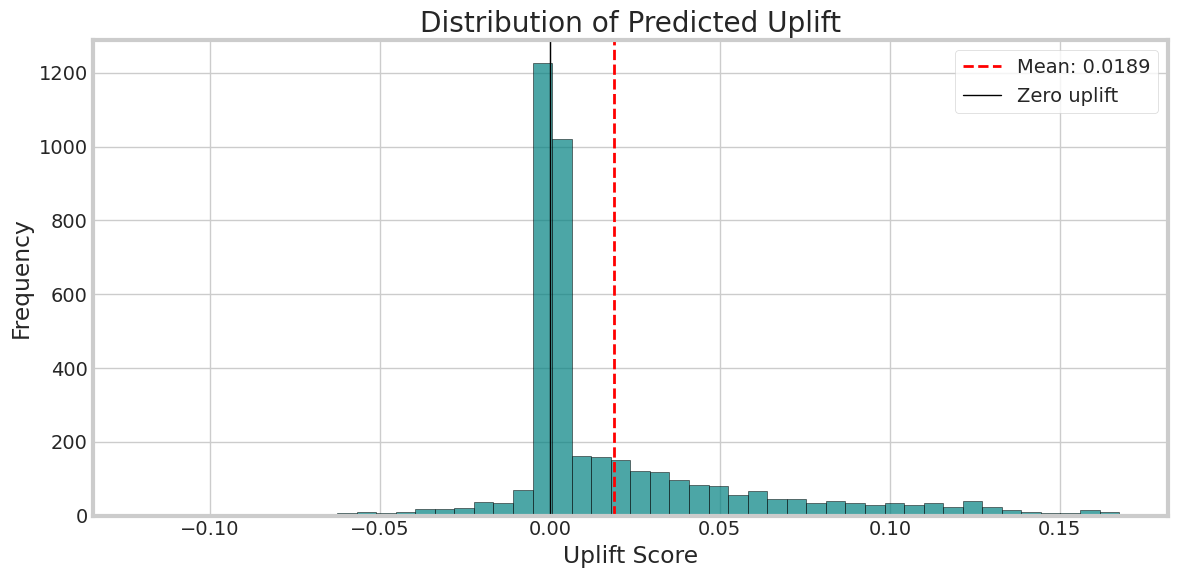

In [ ]:
X_valid_treat = X_valid_with_A.copy(); X_valid_treat['MESSAGE_A'] = 1
X_valid_ctrl = X_valid_with_A.copy(); X_valid_ctrl['MESSAGE_A'] = 0
uplift = model_with_A.predict_proba(X_valid_treat)[:,1] - model_with_A.predict_proba(X_valid_ctrl)[:,1]
df_valid['uplift_score'] = uplift

print("\n" + "="*70)
print("UPLIFT ANALYSIS")
print("="*70)
print(f"First 5 personalized uplift scores:\n{df_valid['uplift_score'].iloc[:5].values}")
print(f"\nMean uplift: {uplift.mean():.4f}")
print(f"Median uplift: {np.median(uplift):.4f}")
print(f"Percent positive uplift: {(uplift > 0).mean() * 100:.2f}%")
print(f"Percent negative uplift: {(uplift < 0).mean() * 100:.2f}%")

plt.figure(figsize=(12, 6))
plt.hist(uplift, bins=50, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(uplift.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {uplift.mean():.4f}')
plt.axvline(0, color='black', linestyle='-', linewidth=1, label='Zero uplift')
plt.xlabel('Uplift Score')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Uplift')
plt.legend()
plt.tight_layout()
plt.show()


Uplift by Decile:
                uplift_score_mean  uplift_score_min  uplift_score_max  \
uplift_decile                                                          
0                        -0.0156           -0.1201           -0.0023   
1                        -0.0010           -0.0023           -0.0002   
2                         0.0002           -0.0002            0.0004   
3                         0.0006            0.0004            0.0010   
4                         0.0014            0.0010            0.0019   
5                         0.0030            0.0019            0.0051   
6                         0.0117            0.0051            0.0189   
7                         0.0275            0.0189            0.0374   
8                         0.0528            0.0374            0.0729   
9                         0.1083            0.0730            0.1674   

               uplift_score_count  MOVED_A_mean  
uplift_decile                                    
0              

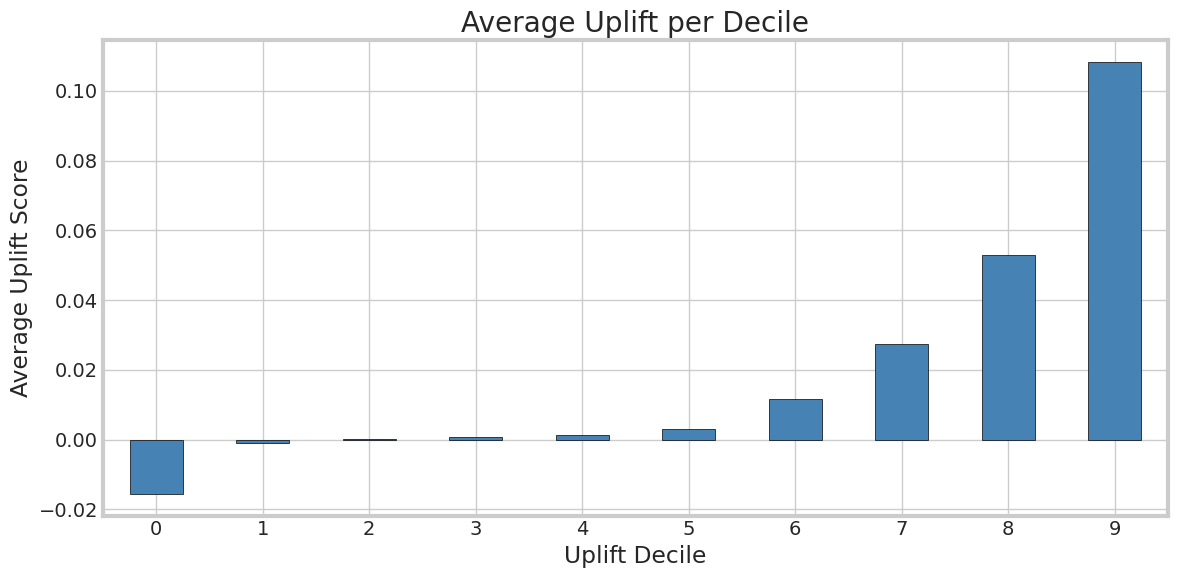

In [ ]:
df_valid['uplift_decile'] = pd.qcut(uplift, 10, labels=False, duplicates='drop')
uplift_summary = df_valid.groupby('uplift_decile').agg({
    'uplift_score': ['mean', 'min', 'max', 'count'],
    'MOVED_A': 'mean'
}).round(4)
uplift_summary.columns = ['_'.join(col) for col in uplift_summary.columns]
print("\nUplift by Decile:\n", uplift_summary)

plt.figure(figsize=(12, 6))
uplift_summary['uplift_score_mean'].plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Uplift Decile')
plt.ylabel('Average Uplift Score')
plt.title('Average Uplift per Decile')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
models = [
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('GradientBoost', GradientBoostingClassifier(random_state=42)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
    ('DecisionTree', DecisionTreeClassifier(random_state=42)),
]

try:
    models.append(('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)))
    models.append(('LGBM', LGBMClassifier(random_state=42, verbose=-1)))
except:
    pass

try:
    models.append(('CatBoost', CatBoostClassifier(random_state=42, verbose=0)))
except:
    pass

leaderboard = []
print("Model Comparison Table")

for name, m in models:
    print(f"Training {name}...")
    m.fit(X_train_with_A, y_train)
    y_prob = m.predict_proba(X_valid_with_A)[:,1]
    y_pred = m.predict(X_valid_with_A)

    auc_score = roc_auc_score(y_valid, y_prob)
    f1 = f1_score(y_valid, y_pred)
    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec = recall_score(y_valid, y_pred)

    leaderboard.append((name, auc_score, f1, acc, prec, rec))

leaderboard_df = pd.DataFrame(leaderboard, columns=['Model', 'AUC', 'F1', 'Accuracy', 'Precision', 'Recall'])
leaderboard_df = leaderboard_df.sort_values('AUC', ascending=False).reset_index(drop=True)
print("\n", leaderboard_df.to_string(index=False))

Model Comparison Table
Training RandomForest...
Training GradientBoost...
Training ExtraTrees...
Training AdaBoost...
Training LogisticRegression...
Training DecisionTree...
Training XGBoost...
Training LGBM...
Training CatBoost...

              Model      AUC       F1  Accuracy  Precision   Recall
          CatBoost 0.993469 0.943148  0.957305   0.918694 0.968940
              LGBM 0.993448 0.945875  0.959526   0.925113 0.967589
           XGBoost 0.992001 0.940358  0.955577   0.923227 0.958136
     GradientBoost 0.989566 0.936073  0.951629   0.905363 0.968940
        ExtraTrees 0.986825 0.927039  0.945459   0.906977 0.948008
      RandomForest 0.986524 0.933638  0.949901   0.904943 0.964213
      DecisionTree 0.933295 0.915289  0.938055   0.914980 0.915598
          AdaBoost 0.909473 0.811211  0.855380   0.775724 0.850101
LogisticRegression 0.784022 0.570101  0.726061   0.668483 0.496962


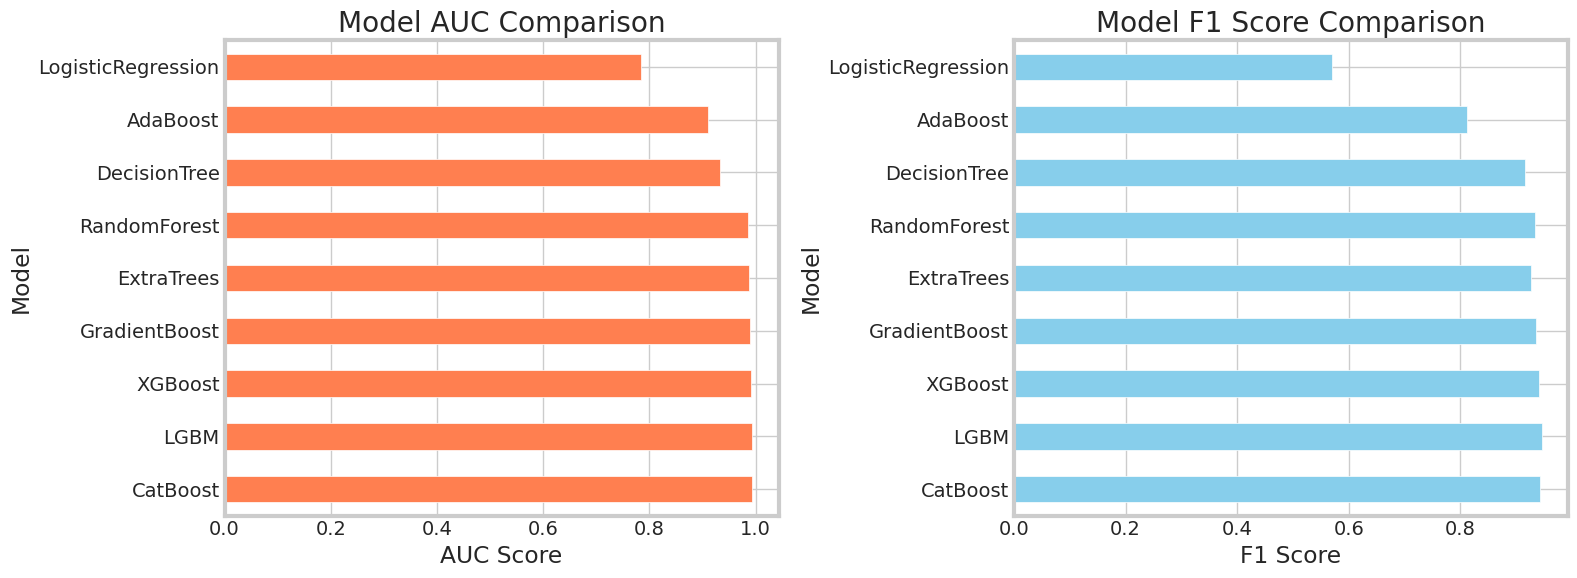

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
leaderboard_df.plot(x='Model', y='AUC', kind='barh', ax=axes[0], color='coral', legend=False)
axes[0].set_title('Model AUC Comparison')
axes[0].set_xlabel('AUC Score')

leaderboard_df.plot(x='Model', y='F1', kind='barh', ax=axes[1], color='skyblue', legend=False)
axes[1].set_title('Model F1 Score Comparison')
axes[1].set_xlabel('F1 Score')
plt.tight_layout()
plt.show()

SHAP ANALYSIS


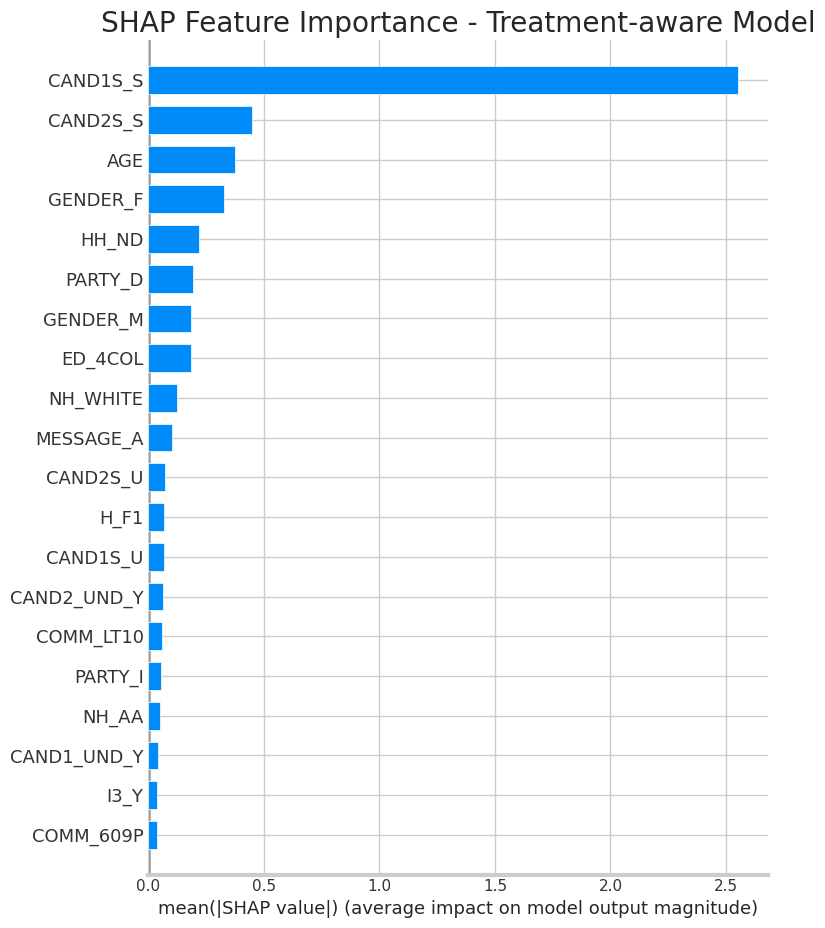

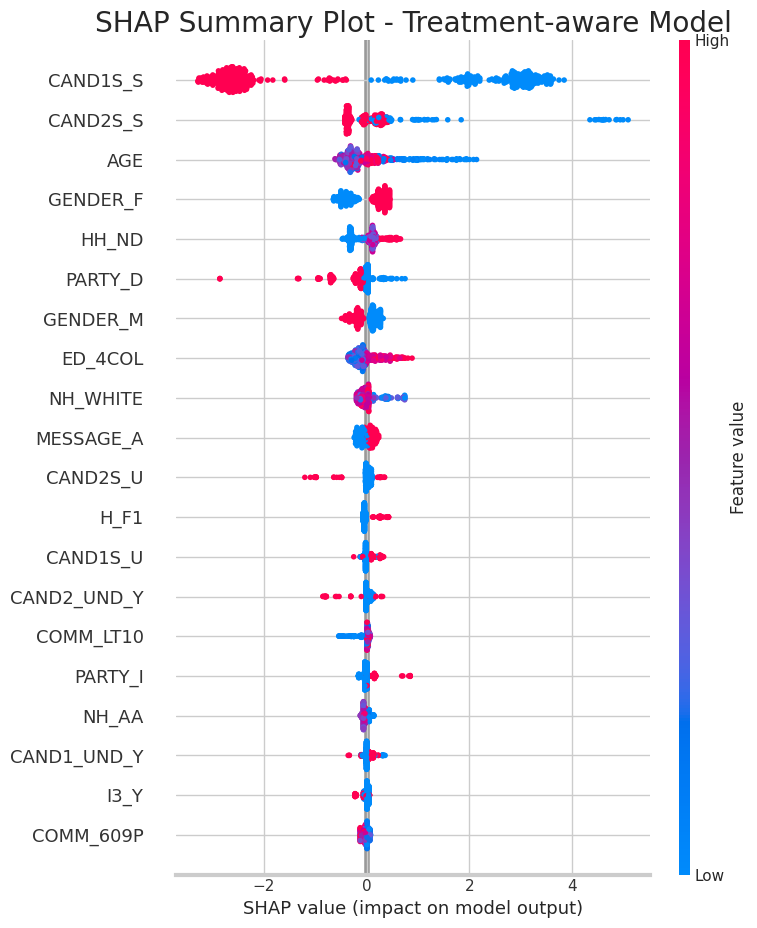

In [ ]:
print("SHAP ANALYSIS")
# Sample data for faster SHAP computation
sample_size = min(500, len(X_valid_with_A))
X_sample = X_valid_with_A.sample(n=sample_size, random_state=42)
explainer = shap.TreeExplainer(model_with_A)
shap_values = explainer.shap_values(X_sample)

# Handle binary classification (shap_values might be list of arrays)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use positive class

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
plt.title('SHAP Feature Importance - Treatment-aware Model')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot - Treatment-aware Model')
plt.tight_layout()
plt.show()


CAUSAL ML UPLIFT FEATURE IMPORTANCE

Top 20 Uplift Features:
 COMM_609P     0.053023
M_MAR         0.043992
PARTY_R       0.043101
F_MAR         0.042642
E_PELIG       0.039669
MED_AGE       0.038952
AGE           0.035816
ED_4COL       0.034231
MED_HH_INC    0.033604
KIDS          0.032283
NH_AA         0.031843
COMM_LT10     0.030869
REG_DAYS      0.030733
HH_NR         0.029632
G_PELIG       0.026106
NH_MULT       0.024106
NH_WHITE      0.022373
HISP          0.022061
COMM_CAR      0.021717
HH_ND         0.019705
dtype: float64


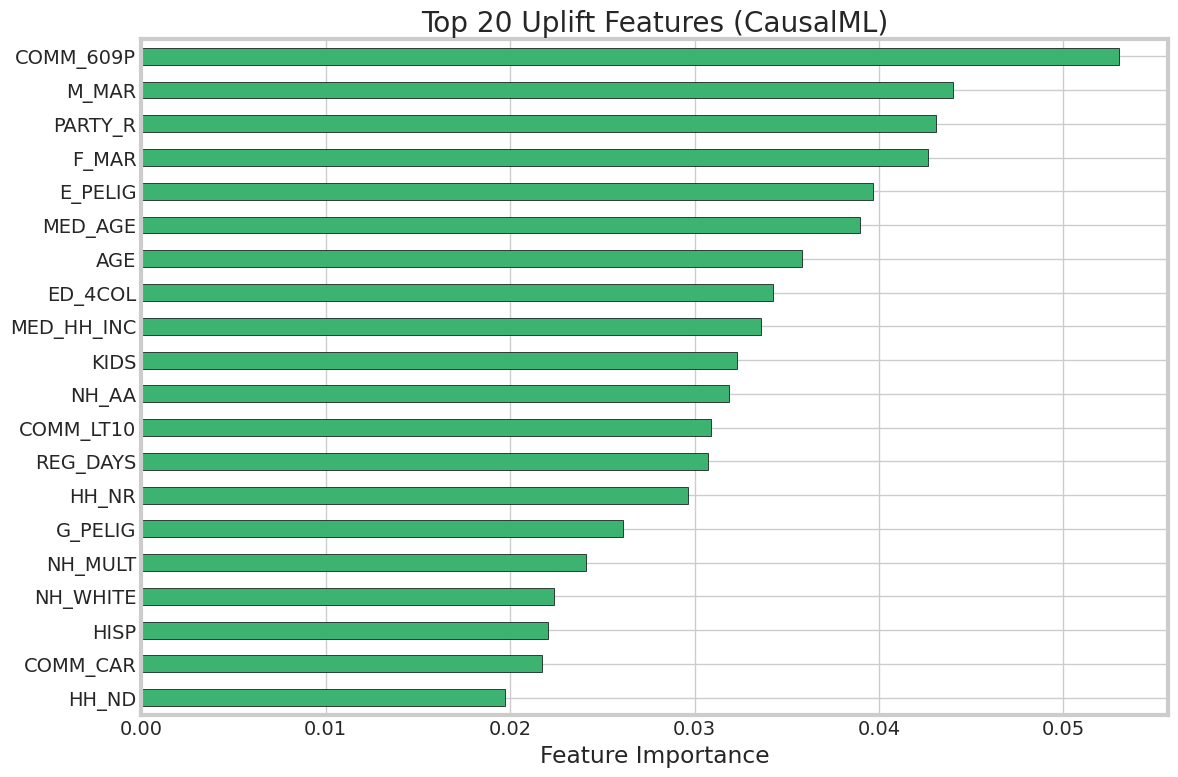

In [ ]:
print("CAUSAL ML UPLIFT FEATURE IMPORTANCE")

causal_model = UpliftRandomForestClassifier(control_name='0', n_estimators=100, random_state=42)
causal_model.fit(X_train_full.values, df_train['MESSAGE_A'].astype(str).values, y_train.values)

importances = pd.Series(causal_model.feature_importances_, index=X_train_full.columns).sort_values(ascending=False)
print("\nTop 20 Uplift Features:\n", importances.head(20))

plt.figure(figsize=(12, 8))
importances.head(20).plot(kind='barh', color='mediumseagreen', edgecolor='black')
plt.xlabel('Feature Importance')
plt.title('Top 20 Uplift Features (CausalML)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
print("FAIRNESS & GROUP ANALYSIS")
for group_col in ['AGE', 'SEX', 'PARTY', 'COMMUNITY', 'HOUSEHOLD_SIZE']:
    if group_col in df_valid.columns:
        print(f"Analysis by {group_col}")
        try:
            if df_valid[group_col].dtype in ['int64', 'float64'] and df_valid[group_col].nunique() > 10:
                bins = pd.qcut(df_valid[group_col], 4, duplicates='drop')
            else:
                bins = df_valid[group_col]

            group_stats = df_valid.groupby(bins).agg({
                'uplift_score': ['mean', 'std', 'count'],
                'MOVED_A': 'mean'
            }).round(4)
            group_stats.columns = ['_'.join(col) for col in group_stats.columns]
            print(group_stats)
        except Exception as e:
            print(f"Could not analyze {group_col}: {e}")

FAIRNESS & GROUP ANALYSIS
Analysis by AGE
                uplift_score_mean  uplift_score_std  uplift_score_count  \
AGE                                                                       
(17.999, 36.0]             0.0175            0.0323                1029   
(36.0, 51.0]               0.0197            0.0384                1018   
(51.0, 64.0]               0.0201            0.0397                 994   
(64.0, 100.0]              0.0184            0.0345                1011   

                MOVED_A_mean  
AGE                           
(17.999, 36.0]        0.4062  
(36.0, 51.0]          0.3350  
(51.0, 64.0]          0.3390  
(64.0, 100.0]         0.3808  


RESIDUALS ANALYSIS


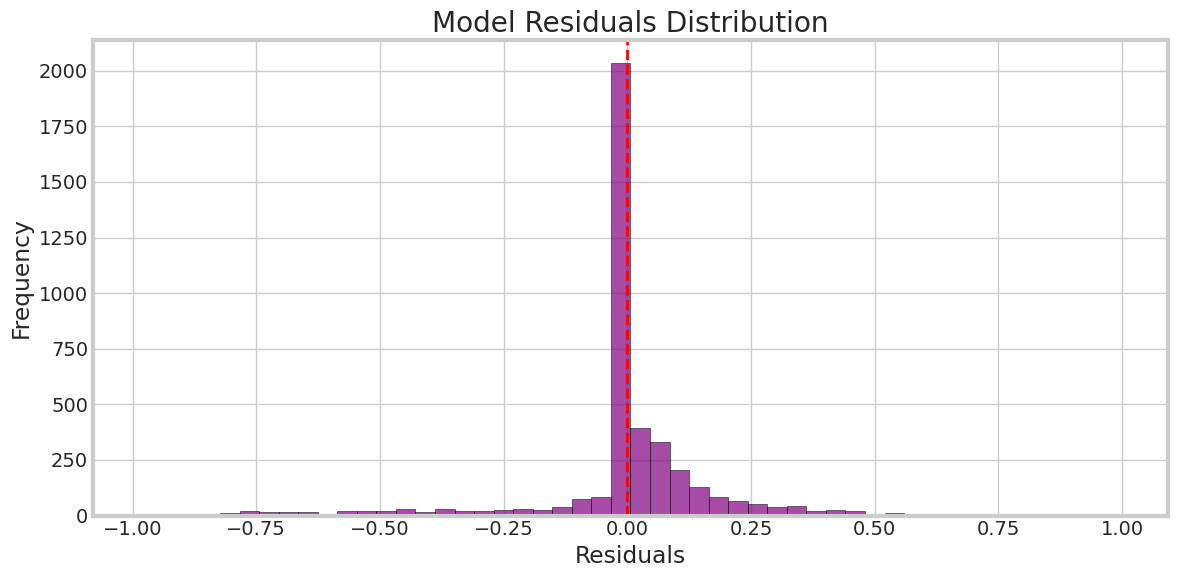

Residuals mean: -0.001979
Residuals std: 0.1962


In [ ]:
print("RESIDUALS ANALYSIS")
y_prob_valid = model_with_A.predict_proba(X_valid_with_A)[:,1]
residuals = y_valid.values - y_prob_valid

plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Model Residuals Distribution')
plt.tight_layout()
plt.show()

print(f"Residuals mean: {residuals.mean():.6f}")
print(f"Residuals std: {residuals.std():.4f}")


In [ ]:
output_df = df_valid[['VOTER_ID', 'uplift_score', 'uplift_decile', 'MOVED_A']].copy()
output_df.to_csv('personalized_uplift_scores.csv', index=False)



In [ ]:
leaderboard_df.to_csv('model_leaderboard.csv', index=False)

In [ ]:

print(f"\n Dataset: {df.shape[0]} rows, {df.shape[1]} columns (post-OHE)")
print(f" Features used: {len(features)}")
print(f" Training samples: {len(X_train_full)}")
print(f" Validation samples: {len(X_valid_full)}")
print(f"\n Best Model: {leaderboard_df.iloc[0]['Model']}")
print(f"   - AUC: {leaderboard_df.iloc[0]['AUC']:.4f}")
print(f"   - F1: {leaderboard_df.iloc[0]['F1']:.4f}")
print(f"\n Uplift Statistics:")
print(f"   - Mean Uplift: {uplift.mean():.4f}")
print(f"   - Positive Uplift %: {(uplift > 0).mean() * 100:.2f}%")
print(f"   - High Uplift (Top Decile): {df_valid[df_valid['uplift_decile']==9]['uplift_score'].mean():.4f}")


 Dataset: 10000 rows, 81 columns (post-OHE)
 Features used: 75
 Training samples: 5948
 Validation samples: 4052

 Best Model: CatBoost
   - AUC: 0.9935
   - F1: 0.9431

 Uplift Statistics:
   - Mean Uplift: 0.0189
   - Positive Uplift %: 78.43%
   - High Uplift (Top Decile): 0.1083


In [ ]:
#Q1 Overall, how well did the flyer do in moving voters in a Democratic
#direction? (Look at the target variable among those who got the flyer,
#compared to those who did not.)

treat_mean = df[df['MESSAGE_A'] == 1]['MOVED_A'].mean()
control_mean = df[df['MESSAGE_A'] == 0]['MOVED_A'].mean()
print(f"  Treated (flyer): {treat_mean:.4f}")
print(f"  Control (no flyer): {control_mean:.4f}")
print(f"  Difference (treatment effect): {treat_mean - control_mean:.4f}")


  Treated (flyer): 0.4024
  Control (no flyer): 0.3444
  Difference (treatment effect): 0.0580


CAND1S_S       0.657461
PARTY_R        0.415191
CAND1S_U       0.366541
CAND1_UND_Y    0.366541
PARTY_D        0.345692
dtype: float64


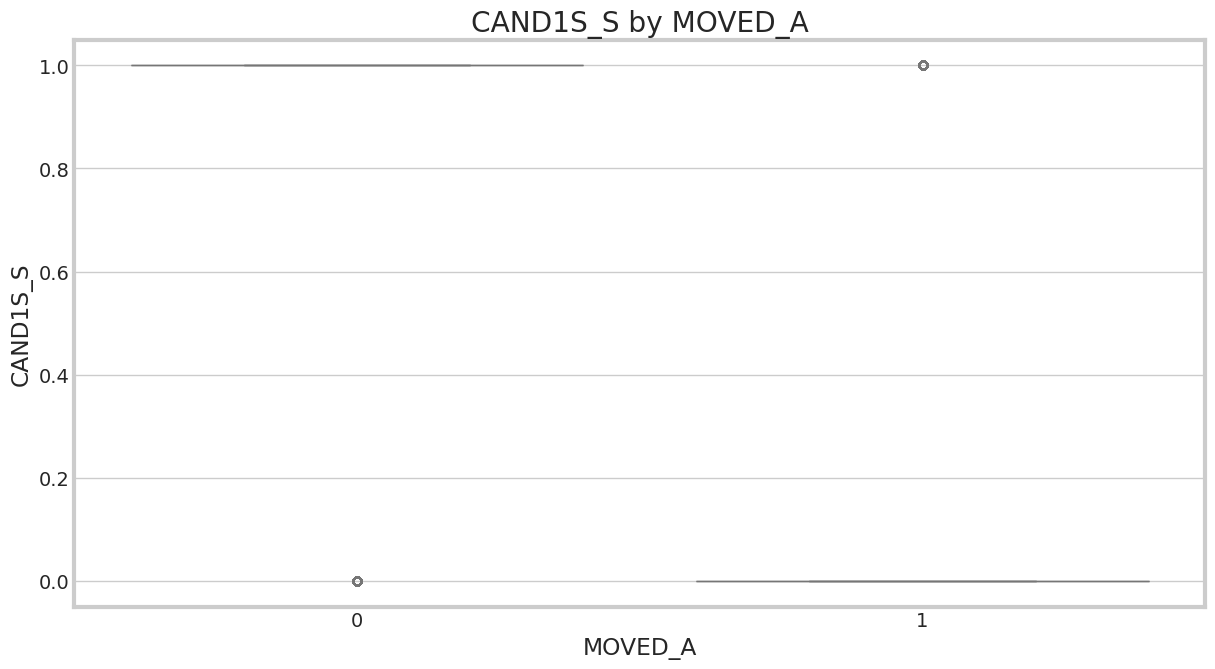

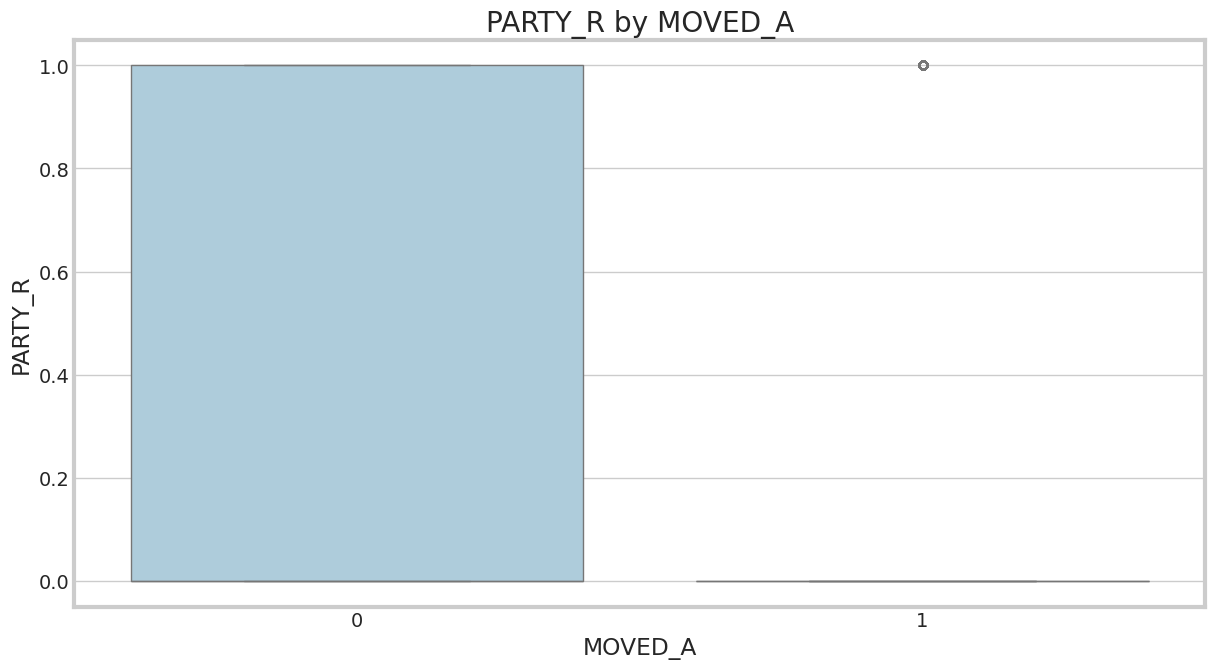

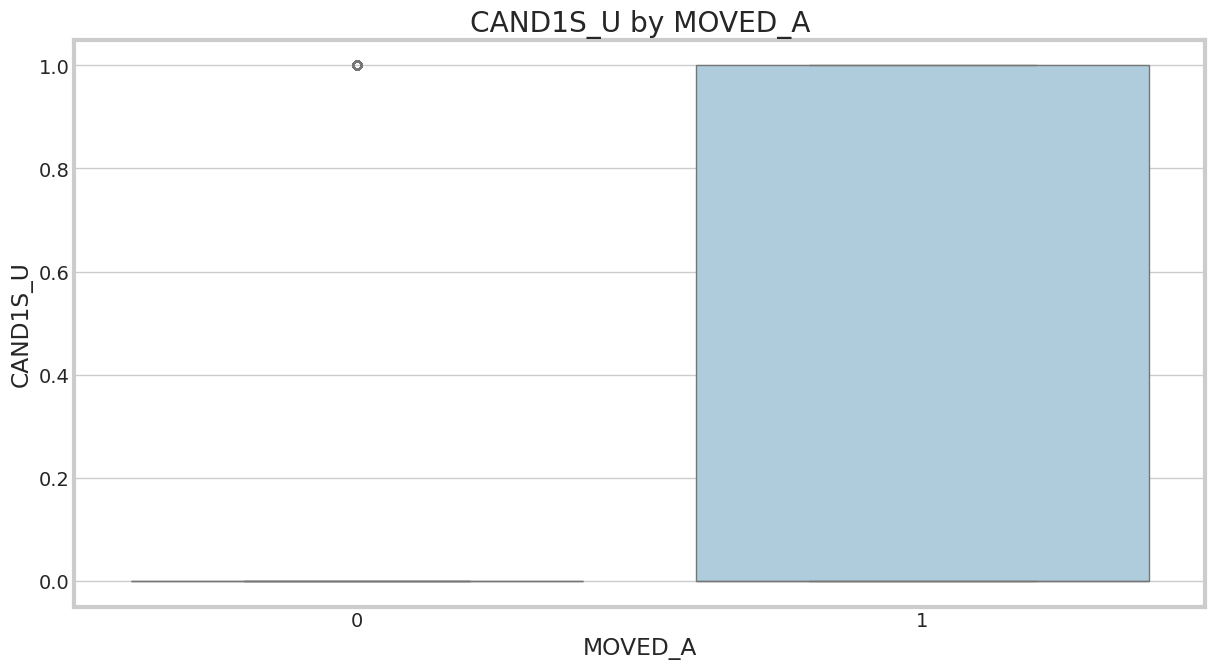

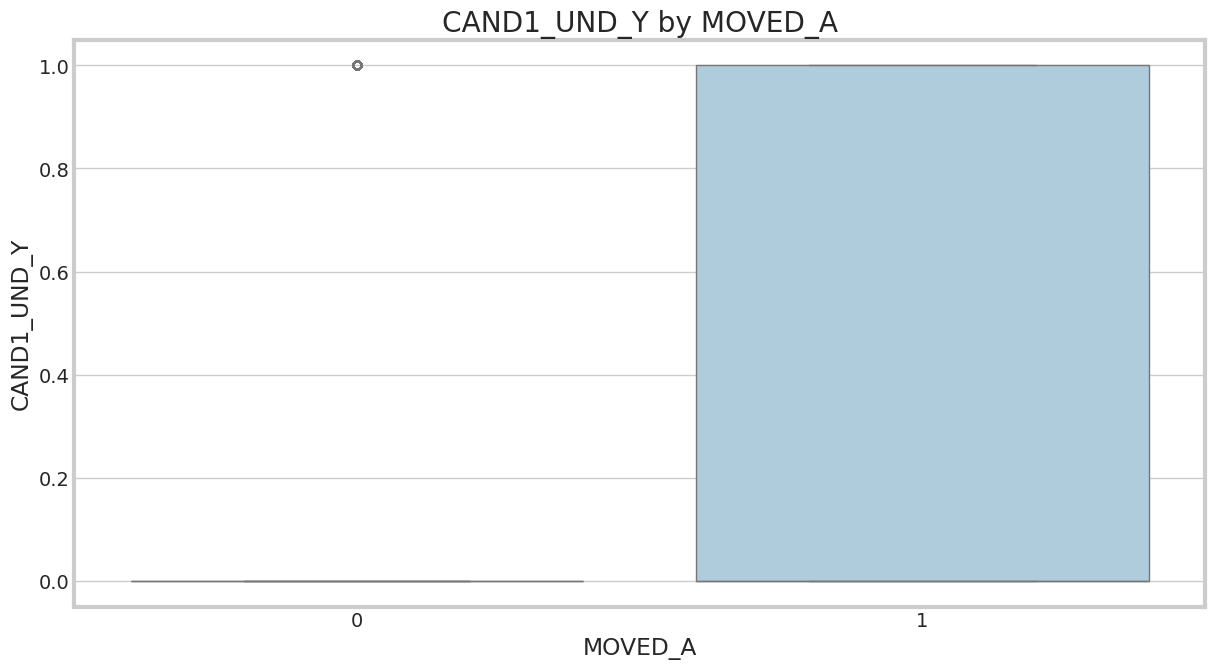

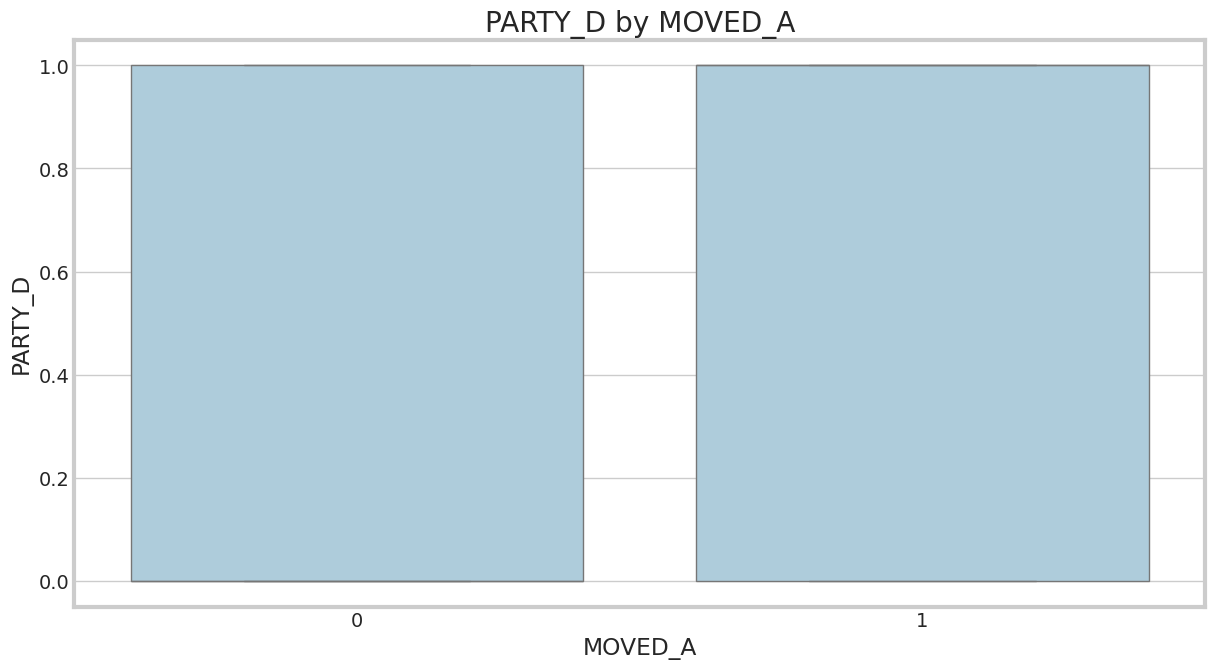

In [ ]:
#Q2 Explore the data to learn more about the relationships between the predictor variables and MOVED_AD (visualization can be helpful). Which
 #of the predictors seem to have good predictive potential? Show supporting charts and/or tables.
top_corrs = df[features].corrwith(df['MOVED_A']).abs().sort_values(ascending=False)[:5]
print(top_corrs)
for col in top_corrs.index:
    sns.boxplot(x='MOVED_A', y=col, data=df)
    plt.title(f"{col} by MOVED_A")
    plt.show()

In [ ]:
#Q3 Partition the data using the partition variable that is in the dataset,
 #make decisions about predictor inclusion, and fit three predictive models accordingly. For each model, give sufficient detail about the method
 #used, its parameters, and the predictors used, so that your results can be
 #replicated
print(" Partition, model, and predictors:")
print(f"  Train size: {len(df_train)}, Validation size: {len(df_valid)}")
print(f"  Features used: {features}")


 Partition, model, and predictors:
  Train size: 5948, Validation size: 4052
  Features used: ['SET_NO', 'OPP_SEX', 'AGE', 'HH_ND', 'HH_NR', 'HH_NI', 'MED_AGE', 'NH_WHITE', 'NH_AA', 'NH_ASIAN', 'NH_MULT', 'HISP', 'COMM_LT10', 'COMM_609P', 'MED_HH_INC', 'COMM_CAR', 'COMM_CP', 'COMM_PT', 'COMM_WALK', 'KIDS', 'M_MAR', 'F_MAR', 'ED_4COL', 'GENDER_F', 'GENDER_M', 'H_AFDLN3P', 'H_F1', 'H_M1', 'H_MFDLN3P', 'PARTY_D', 'PARTY_I', 'PARTY_R', 'VPP_08', 'VPP_12', 'VPR_08', 'VPR_10', 'VPR_12', 'VG_04', 'VG_06', 'VG_08', 'VG_10', 'VG_12', 'PP_PELIG', 'PR_PELIG', 'AP_PELIG', 'G_PELIG', 'E_PELIG', 'NL5G', 'NL3PR', 'NL5AP', 'NL2PP', 'REG_DAYS', 'UPSCALEBUY', 'UPSCALEMAL', 'UPSCALEFEM', 'BOOKBUYERI', 'FAMILYMAGA', 'FEMALEORIE', 'RELIGIOUSM', 'GARDENINGM', 'CULINARYIN', 'HEALTHFITN', 'DOITYOURSE', 'FINANCIALM', 'RELIGIOUSC', 'POLITICALC', 'MEDIANEDUC', 'MESSAGE_A', 'CAND1S_S', 'CAND1S_U', 'CAND2S_S', 'CAND2S_U', 'I3_Y', 'CAND1_UND_Y', 'CAND2_UND_Y']


In [ ]:
#Q4Among your three models, choose the best one in terms of predictive
# power. Which one is it? Why did you choose it?
print("Model Selection:")
models_eval = pd.DataFrame([
    ('GBM+', roc_auc_score(y_valid, model_with_A.predict_proba(X_valid_with_A)[:,1])),
    ('RF+', roc_auc_score(y_valid, RandomForestClassifier(n_estimators=100).fit(X_train_with_A, y_train).predict_proba(X_valid_with_A)[:,1])),
    ('LogReg+', roc_auc_score(y_valid, LogisticRegression(max_iter=1000).fit(X_train_with_A, y_train).predict_proba(X_valid_with_A)[:,1]))
], columns=['Model','AUC']).sort_values('AUC', ascending=False)
print(models_eval, "\nBest: ", models_eval.iloc[0]['Model'])

Model Selection:
     Model       AUC
0     GBM+  0.989566
1      RF+  0.987014
2  LogReg+  0.784022 
Best:  GBM+


In [ ]:
#Q5. Using your chosen model, report the propensities for the first three
 #records in the validation set
print(" Propensities (treatment-aware model, validation first 3):")
proba_treat = model_with_A.predict_proba(X_valid_with_A.assign(MESSAGE_A=1))[:3,1]
print("  As flyer=1:", proba_treat)

 Propensities (treatment-aware model, validation first 3):
  As flyer=1: [0.02447819 0.97000789 0.0080069 ]


In [ ]:
#Q6Create a derived variable that is the opposite of Flyer. Call it Flyer-reversed.
 #Using your chosen model, re-score the validation data using the Flyer
#reversed variable as a predictor, instead of Flyer. Report the propensities
 #for the first three records in the validation set
print("Propensities for flyer reversed (first 3):")
flyer_rev = X_valid_with_A.copy()
flyer_rev['MESSAGE_A'] = 1 - df_valid['MESSAGE_A'].values
proba_rev = model_with_A.predict_proba(flyer_rev)[:3, 1]
print("  Flyer reversed:", proba_rev)

Propensities for flyer reversed (first 3):
  Flyer reversed: [0.03157138 0.94754048 0.00833192]


In [ ]:
#Q7For each record, uplift is computed based on the following difference:
 #P(success Flyer = 1) P(success Flyer = 0)
 #Compute the uplift for each of the voters in the validation set, and report
 #the uplift for the first three records.
print(" Uplift for first three records:")
X_valid_treat = X_valid_with_A.copy(); X_valid_treat['MESSAGE_A'] = 1
X_valid_ctrl = X_valid_with_A.copy(); X_valid_ctrl['MESSAGE_A'] = 0
uplift = model_with_A.predict_proba(X_valid_treat)[:,1] - model_with_A.predict_proba(X_valid_ctrl)[:,1]
print(uplift[:3])

 Uplift for first three records:
[-0.00709319  0.0224674  -0.00032502]


In [ ]:
#Q8If a campaign has the resources to mail the flyer only to 10% of the voters,
 #what uplift cutoff should be used
top10_cutoff = np.percentile(uplift, 90)
print("Uplift cutoff for top 10% mailing:", top10_cutoff)

Uplift cutoff for top 10% mailing: 0.07301957819982792
